# Material correspondente à Aula 05 - Avaliação de modelos generativos com enfase em GANS

### Inspirado em: *DeepLearning.AI*, *Kaggle* e *Machine Learning Mastery*


## Installing packages

In [ ]:
!pip install torchvision==0.15.0
!pip install torch
!pip install matplotlib

## Importing modules

In [54]:
import torch
import numpy as np
import scipy
import pandas as pd
from tqdm.auto import tqdm

from torch import nn
from torch.distributions import MultivariateNormal
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.models import inception_v3
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(0)

### Criando a classe do gerador

> **A classe Generator implementa um gerador para um Deep Convolutional GAN (DCGAN). Ela usa camadas convolucionais transpostas para gerar imagens a partir de vetores de ruído.**

In [64]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    '''
    Classe Gerador
    Argumentos:
        z_dim: dimensão do vetor de ruído, um escalar.
        im_chan: número de canais nas imagens geradas, ajustado ao conjunto de dados utilizado, um escalar.
                 (Por exemplo, CelebA utiliza RGB, então o padrão é 3).
        hidden_dim: dimensão interna das camadas, um escalar.
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Construção da rede neural
        self.gen = nn.Sequential(
            self._criar_bloco_gerador(z_dim, hidden_dim * 8),
            self._criar_bloco_gerador(hidden_dim * 8, hidden_dim * 4),
            self._criar_bloco_gerador(hidden_dim * 4, hidden_dim * 2),
            self._criar_bloco_gerador(hidden_dim * 2, hidden_dim),
            self._criar_bloco_gerador(hidden_dim, im_chan, kernel_size=4, camada_final=True),
        )

    def _criar_bloco_gerador(self, canais_entrada, canais_saida, kernel_size=3, stride=2, camada_final=False):
        '''
        Cria um bloco do gerador para o DCGAN, contendo:
        - Convolução transposta
        - BatchNorm (exceto na camada final)
        - Função de ativação
        Argumentos:
            canais_entrada: número de canais na representação de entrada.
            canais_saida: número de canais na representação de saída.
            kernel_size: tamanho do filtro convolucional (kernel_size, kernel_size).
            stride: passo da convolução.
            camada_final: booleano, True se for a camada final; afeta a ativação e o BatchNorm.
        '''
        if not camada_final:
            return nn.Sequential(
                nn.ConvTranspose2d(canais_entrada, canais_saida, kernel_size, stride),
                nn.BatchNorm2d(canais_saida),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(canais_entrada, canais_saida, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, ruido):
        '''
        Passagem direta do gerador. Dado um tensor de ruído, retorna imagens geradas.
        Argumentos:
            ruido: tensor de ruído com dimensões (n_amostras, z_dim).
        '''
        x = ruido.view(len(ruido), self.z_dim, 1, 1)  # Redimensiona o ruído para a forma esperada
        return self.gen(x)

def gerar_ruido(n_amostras, z_dim, device='cpu'):
    '''
    Cria vetores de ruído aleatórios com dimensões (n_amostras, z_dim).
    Argumentos:
        n_amostras: número de vetores de ruído a serem gerados.
        z_dim: dimensão de cada vetor de ruído.
        device: dispositivo onde os tensores serão alocados ('cpu' ou 'cuda').
    Retorna:
        Tensor de ruído aleatório.
    '''
    return torch.randn(n_amostras, z_dim, device=device)


In [65]:
# Dimensão do vetor latente (z_dim) usado como entrada para o modelo gerador
z_dim = 64

# Dimensão de saída da imagem (em pixels)
image_size = 299

# Define o dispositivo padrão como CPU
device = 'cpu'

# Verifica se há uma GPU disponível e, caso positivo, muda o dispositivo para CUDA (GPU)
if torch.cuda.is_available():
    device = 'cuda'

# Define uma sequência de transformações para preprocessamento das imagens
transform = transforms.Compose([
    # Redimensiona a imagem para o tamanho especificado (299x299)
    transforms.Resize(image_size),

    # Realiza um recorte central na imagem para garantir o tamanho correto
    transforms.CenterCrop(image_size),

    # Converte a imagem para um tensor do PyTorch, normalizando automaticamente os valores para [0, 1]
    transforms.ToTensor(),

    # Normaliza os valores dos pixels para o intervalo [-1, 1]
    # (0.5, 0.5, 0.5) é a média para cada canal (R, G, B)
    # (0.5, 0.5, 0.5) é o desvio padrão para cada canal (R, G, B)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### Carregando GAN pré-treinada

> **O CelebA (CelebFaces Attributes Dataset) é um conjunto de dados amplamente utilizado em pesquisas de visão computacional, especialmente em tarefas relacionadas ao reconhecimento facial, edição de imagens e geração de imagens (como GANs). Ele contém mais de 200.000 imagens de rostos de celebridades, acompanhadas de 40 atributos faciais anotados (por exemplo, óculos, barba, sorriso) e localizações das principais características faciais. Para acessá-lo clique [aqui](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)**




In [66]:
# Carrega os dados de um arquivo .npz que contem features extraídas de imagens
data = torch.Tensor(np.load('/content/drive/MyDrive/models/fid_images_tensor.npz', allow_pickle=True)['arr_0'])

# Cria um TensorDataset dataset utilizando o PyTorch, onde os dados são usados tanto como entradas quanto como rótulos
# TensorDataset associa duas ou mais fontes de dados (neste caso, data e data) para serem usados como pares (x, y) em treinamento ou avaliação.
dataset = torch.utils.data.TensorDataset(data, data)


In [67]:
# Inicializa o gerador com a dimensão do vetor latente (z_dim) e move para o dispositivo especificado (CPU ou GPU)
gen = Generator(z_dim).to(device)

# Carrega o modelo pré-treinados Celeba
gen.load_state_dict(
    torch.load("/content/drive/MyDrive/models/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
)

# Define o modelo gerador no modo de avaliação (evaluation mode)
gen = gen.eval()


<ipython-input-67-519d232e4809>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/content/drive/MyDrive/models/pretrained_celeba.pth", map_location=torch.device(

## Carregando modelo pré-treinado


### Inception-v3 Network

> **Inception-V3 é uma rede neural treinada no [ImageNet](http://www.image-net.org/) para classificar objetos. Você deve se lembrar das palestras que o ImageNet tem mais de 1 milhão de imagens para treinar. Como resultado, o Inception-V3 faz um bom trabalho detectando recursos e classificando imagens. Aqui, você carregará o Inception-V3 como inception_model.**

In [68]:
# Importa o modelo Inception v3 do PyTorch
inception_model = inception_v3(pretrained = False)

# Carrega os pesos pré-treinados para o modelo Inception v3
inception_model.load_state_dict(torch.load("/content/drive/MyDrive/models/inception_v3_google-1a9a5a14.pth"))

# Move o modelo para o dispositivo especificado (CPU ou GPU)
inception_model.to(device)

# Define o modelo em modo de avaliação (evaluation mode)
# Isso desativa o comportamento de dropout e batch normalization no modo de treinamento,
# garantindo que o modelo opere de forma determinística durante a inferência.
inception_model = inception_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
<ipython-input-68-1e91d999f33f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the

#### Removendo a última camada do Inception-v3

> **O Incerption-v3 foi projetado para tarefas de classificação de imagens, como a última camada produzindo as probabilidades associadas às classes. Para o FID, no entanto, precisamos dos atributos extraidos da penúltima camada (*pooling*), correspondendo aos vetores de alta dimensão.**



In [69]:
inception_model.fc = torch.nn.Identity()

### Implementando Frechet Incerption Distance (FID)

In [70]:
def matrix_sqrt(x):
    '''
    Função que recebe uma matriz e retorna a raiz quadrada dessa matriz.
    Para uma matriz de entrada A, a matriz de saída B será tal que B @ B é igual à matriz A.
    Parâmetros:
        x: uma matriz (Tensor do PyTorch)
    Retorna:
        A raiz quadrada da matriz x como um Tensor do PyTorch
    '''
    # Converter o tensor para numpy, garantindo que ele esteja na CPU e sem gradiente
    y = x.cpu().detach().numpy()

    # Calcular a raiz quadrada da matriz usando scipy.linalg.sqrtm
    y = scipy.linalg.sqrtm(y)

    # Retornar o resultado como um Tensor do PyTorch no mesmo dispositivo do tensor original
    return torch.tensor(y.real, device=x.device)

In [71]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Função que calcula a distância de Fréchet entre distribuições Gaussianas multivariadas,
    parametrizadas por suas médias e matrizes de covariância.

    Parâmetros:
        mu_x: média da primeira Gaussiana, (n_features)
        mu_y: média da segunda Gaussiana, (n_features)
        sigma_x: matriz de covariância da primeira Gaussiana, (n_features, n_features)
        sigma_y: matriz de covariância da segunda Gaussiana, (n_features, n_features)

    Retorna:
        Distância de Fréchet (float).
    '''
    # Diferença entre as médias
    mean_diff = mu_x - mu_y

    # Cálculo da distância de Fréchet
    distance = (mean_diff.dot(mean_diff) +
                torch.trace(sigma_x) +
                torch.trace(sigma_y) -
                2 * torch.trace(matrix_sqrt(sigma_x @ sigma_y)))

    return distance

#### Pre-processamento das imagens



In [72]:
def preprocess(img):
    '''
    Função para preprocessar uma imagem, redimensionando-a para 299x299
    usando interpolação bilinear.

    Parâmetros:
        img: tensor representando a imagem de entrada.

    Retorna:
        A imagem redimensionada como um tensor.
    '''
    # Redimensionar a imagem para 299x299 usando interpolação bilinear
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img


#### Cálculo de covariância

In [73]:
def get_covariance(features):
    '''
    Função para calcular a matriz de covariância de um conjunto de características.

    Parâmetros:
        features: tensor do PyTorch contendo as características (amostras x características).

    Retorna:
        A matriz de covariância como um tensor do PyTorch.
    '''
    # Garantir que os dados sejam convertidos para um array numpy sem gradiente
    features_np = features.detach().numpy()

    # Calcular a matriz de covariância usando numpy, com as colunas como variáveis
    covariance_matrix = np.cov(features_np, rowvar=False)

    # Converter a matriz numpy para um tensor do PyTorch
    return torch.tensor(covariance_matrix, dtype=features.dtype, device=features.device)

#### Extraindo features em imagens reais e geradas

In [74]:
fake_features_list = []  # Lista para armazenar as características das imagens geradas
real_features_list = []  # Lista para armazenar as características das imagens reais

gen.eval()  # Coloca o gerador em modo de avaliação (inference mode)
n_samples = 512  # Número total de amostras a serem processadas
batch_size = 4  # Número de amostras por iteração (tamanho do lote)

# Configura o DataLoader para iterar sobre o dataset real
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True  # Embaralha os dados para evitar ordens repetitivas
)

cur_samples = 0  # Contador de amostras processadas
with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size):  # Processa por lote
            # Obtém as amostras reais
            real_samples = real_example
            # Extrai as características das imagens reais usando o modelo Inception
            real_features = inception_model(real_samples.to(device)).detach().to('cpu')  # Move as características para a CPU
            real_features_list.append(real_features)  # Adiciona à lista de características reais

            # Gera amostras falsas usando ruído como entrada
            fake_samples = get_noise(len(real_example), z_dim).to(device)  # Gera vetores de ruído
            fake_samples = preprocess(gen(fake_samples))  # Gera imagens a partir do gerador e aplica preprocessamento
            # Extrai as características das imagens geradas usando o modelo Inception
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')  # Move as características para a CPU
            fake_features_list.append(fake_features)  # Adiciona à lista de características geradas

            cur_samples += len(real_samples)  # Atualiza o contador de amostras processadas
            if cur_samples >= n_samples:  # Interrompe o loop se o número total de amostras for atingido
                break
    except:
        print("Erro no loop")  # Captura possíveis erros durante o processamento

  0%|          | 0/128 [00:00<?, ?it/s]

In [75]:
# Calcula as estatisticas descritivas entre verdadeiros e falsos (gerados)
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)

sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

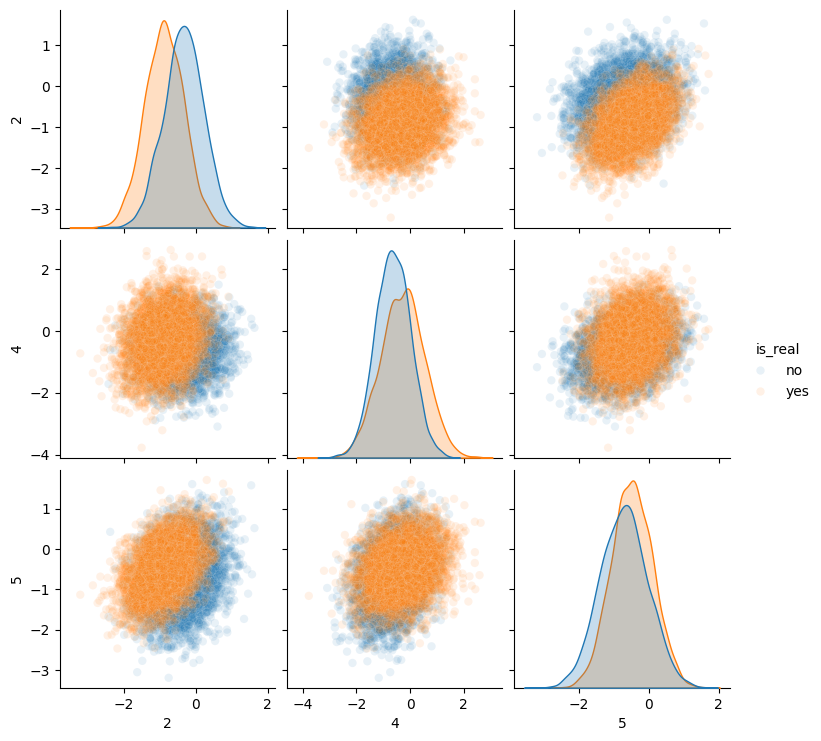

In [76]:
# Seleciona embeddings e o número de amostras
indices = [2, 4, 5]
n_samples = 5000

# Função auxiliar para criar amostras e dataframe
def create_samples(mu, sigma, indices, label):
    dist = MultivariateNormal(mu[indices], sigma[indices][:, indices])
    samples = dist.sample((n_samples,)).numpy()
    df = pd.DataFrame(samples, columns=indices)
    df["is_real"] = label
    return df

# Gerar amostras falsas e reais
df_fake = create_samples(mu_fake, sigma_fake, indices, "no")
df_real = create_samples(mu_real, sigma_real, indices, "yes")

# Combinar e plotar
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

> **As distribuições permitem avaliar o quão bem as amostras geradas (falsas) replicam as características estatísticas das amostras reais, como médias, variâncias e correlações, além de identificar discrepâncias ou similaridades entre os dois conjuntos em um espaço multivariado definido pelos índices selecionados.**

---



In [77]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

617.586669921875


#### Inspecionando imagens reais e geradas

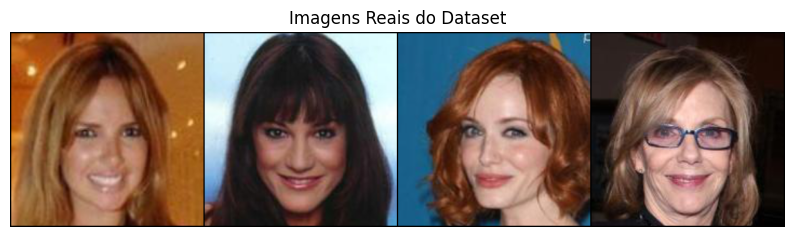

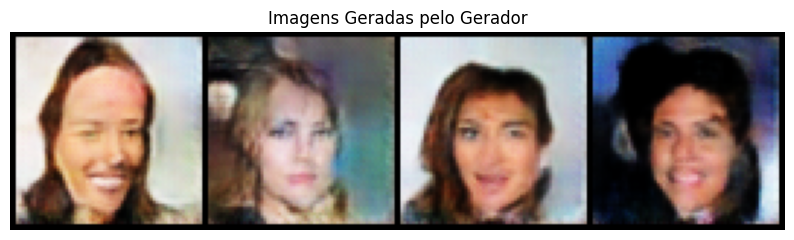

In [79]:
# Função para plotar um lote de imagens
def plot_images(images, title="Imagens"):
    """
    Plota um conjunto de imagens em um grid.
    Parâmetros:
        images: Tensor contendo as imagens no formato (batch_size, C, H, W).
        title: Título do gráfico.
    """
    # Normaliza as imagens para o intervalo [0, 1] para exibição
    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))  # Ajusta as dimensões para exibição (H, W, C)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Visualizar imagens reais
real_images, _ = next(iter(dataloader))  # Obtém o primeiro lote do dataloader
plot_images(real_images, title="Imagens Reais do Dataset")

# Visualizar imagens geradas
gen.eval()  # Garante que o gerador está no modo de avaliação
with torch.no_grad():  # Desativa o cálculo de gradientes para eficiência
    fake_noise = get_noise(batch_size, z_dim, device=device)  # Gera vetores de ruído
    fake_images = gen(fake_noise).detach().cpu()  # Gera imagens e move para CPU
    plot_images(fake_images, title="Imagens Geradas pelo Gerador")

# Com base no observado que outras melhorias poderiam ser empregadas?